## Calculate classical coeffcient $F_j$

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import time
from math import pi

This below `get_new_F_coefs` will calculate the coefficient of $F_j$ automatically, and you only need to specify the parameter `d` and `delta`. You can find the detailed procedure in the Appendix A/B of [this paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010318). Generally, the larger `d` and the smaller `delta` you choose, the more precise your approximate step function will be. However, the step function will be distorted if the `delta` is too small. For reference, we suggest `delta=4/d` as a try.

The calculation could be time-consuming. As a reference, calculation for `d=20k, delta=4/d` will take one hour on a very high-performance CPU. Depending on the specific hardware, you might expect it to take longer.

In [12]:
def get_M(x,d,delta):

    def get_Tn(x,n):
        coef = np.zeros(n+1)
        coef[n] = 1
        return np.polynomial.chebyshev.chebval(x = x, c=coef)
    def integrand(x):
        temp = (np.cos(x) - np.cos(delta))/(1 + np.cos(delta) )
        #temp = (mp.cos(x) - mp.cos(delta))/(1 + mp.cos(delta))
        S = (1 + 2 * temp )
        return get_Tn(x=S,n=d)


    N, e = integrate.quad(integrand,-np.pi,np.pi, limit=d, points = np.linspace(-np.pi,np.pi,d))
    print('error is', e)
    #N = mp.quad(integrand, [-pi, pi])
    
    if d%1000==0:
        print('d=', d)
    return integrand(x)/N

def get_new_F_coefs(d, delta):

    d = d*2+2
    def get_M_fourier(d,delta):
        x = np.arange(-np.pi,np.pi,np.pi/(2*d))

        M_list = get_M(x,d,delta)
        # M_list = []
        # for ele in x:
        #      M_list.append(get_M(ele,d,delta))
        x_ft = np.fft.fft(M_list)/(4*d)
        
        for i,ele in enumerate(x_ft):
            x_ft[i]*=(-1)**i

        return x_ft

    def get_H_fourier(k):
        if k%2 ==0 and k!=0:
            return 0
        elif k==0:
            return np.sqrt(np.pi/2)
        elif k%2 !=0:
            return -1j*2/(np.sqrt(2*np.pi)*k)   

    x = np.arange(-np.pi,np.pi,np.pi/d)
    #M = get_M(x=x,d=d,delta=delta)
    M_fourier = get_M_fourier(d,delta)
    M_fourier = M_fourier[0:d+1]
    H_fourier = np.array([get_H_fourier(k) for k in range(d+1)])
    F = np.sqrt(2*np.pi) * M_fourier *H_fourier

    F_odd = [1j*F[2*i+1].imag for i in range(d//2)]
    return F_odd

def get_F_from_M(M_list,d, delta):
    
    d = d*2+2
    def get_M_fourier(d,delta):
        x = np.arange(-np.pi,np.pi,np.pi/(2*d))
        x_ft = np.fft.fft(M_list)/(4*d)
        for i,ele in enumerate(x_ft):
            x_ft[i]*=(-1)**i

        return x_ft

    def get_H_fourier(k):
        if k%2 ==0 and k!=0:
            return 0
        elif k==0:
            return np.sqrt(np.pi/2)
        elif k%2 !=0:
            return -1j*2/(np.sqrt(2*np.pi)*k)   

    #x = np.arange(-np.pi,np.pi,10000)
    #M = get_M(x=x,d=d,delta=delta)
    M_fourier = get_M_fourier(d,delta)
    M_fourier = M_fourier[0:d+1]
    H_fourier = np.array([get_H_fourier(k) for k in range(d+1)])
    print(len(H_fourier))
    F = np.sqrt(2*np.pi) * M_fourier *H_fourier

    F_odd = [1j*F[2*i+1].imag for i in range(d//2)]
    return F_odd

def get_new_approx_step_function(d, delta):

    x_list = np.linspace(-pi,pi,10000)
    F_coefs = get_new_F_coefs(d, delta)

    F_approx = 0.5*np.ones(len(x_list))

    for j, F in enumerate(F_coefs):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    
    return F_approx.real

def get_step_from_F(F_list):

    d = len(F_list)-1
    x_list = np.linspace(-pi,pi, 100000)
    F_approx = 0.5*np.ones(len(x_list))
    for j, F in enumerate(F_list):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    return F_approx.real

You can try to run the function with the following cell.

In [ ]:
## It takes a long time if your d is large. Keep in mind!

# d=2000
# delta = 4/d
# F_list = get_new_F_coefs(d=d, delta=delta)
# file_name = 'file_name'
# np.save('file_name', F_list)

We already saved some calculated coefficient lists and let's try to look at the precision of our approximated step function.

In [13]:
F_2e4 = np.load('F_list/F_list_d2e4_lim1e4.npy')
step_2e4 = get_step_from_F(F_2e4)
x_list = np.linspace(-pi,pi,int(1e5))


(-0.001, 0.001)

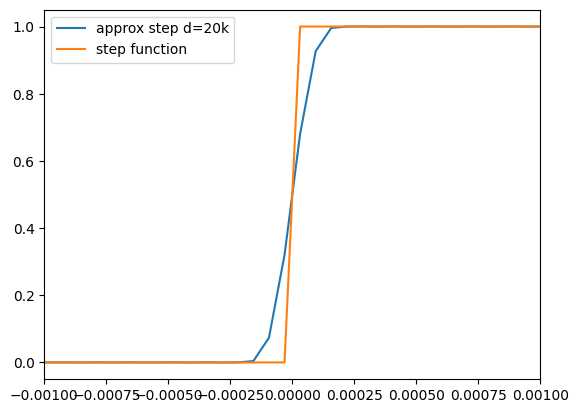

In [14]:
plt.plot(x_list, step_2e4,label='approx step d=20k')
plt.plot(x_list, np.append(np.zeros(len(x_list)//2), np.ones(len(x_list)//2)),label='step function')
plt.legend()
plt.xlim([-0.001,.001])

Our step function already reached 0.0002 precision! Notice that your final precision to find ground state energy will be limited by your F coefficients. Make sure to increase `d` and `delta` if you need more accuracy for your algorithm. 